# **Improving Your Digit Recognition Model From Assignment 1**

For this problem, you will attempt to improve your Digit Recognition Model from Assignment1- problem2. More specifically, you will add the following components:

Modify your create_nn method to use Mini-batch gradient descent (5pt).

1.   Your create_nn method should accept an additional parameter (batch_size). Then instead of updating parameters per entire data, you will create random batches of (batch_size) samples from training data, run forward and backward passes, and update parameters per each batch. Then to get the train_loss for each epoch, you should keep track and average train_losses over batches.

2.   Retrain the model using mini-batch gradient descent you implemented above and interpret the learning curves. Answer the following question:


*   How do training and validation losses compare to the model without minibatch gradient descent?


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, OneHotEncoder
import numpy as np

In [ ]:

# Parameter Initialization
def initialize_parameters(nx, nh1, nh2, ny):
    tf.random.set_seed(1)  # Set random seed for reproducibility
    W1 = tf.Variable(tf.random.normal(shape=(nh1, nx), stddev=0.01), name="W1")
    b1 = tf.Variable(tf.zeros(shape=(nh1, 1), name="b1"))
    W2 = tf.Variable(tf.random.normal(shape=(nh2, nh1), stddev=0.01), name="W2")
    b2 = tf.Variable(tf.zeros(shape=(nh2, 1), name="b2"))
    W3 = tf.Variable(tf.random.normal(shape=(ny, nh2), stddev=0.01), name="W3")
    b3 = tf.Variable(tf.zeros(shape=(ny, 1), name="b3"))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    return parameters

#Forward Pass:

def forward_pass(parameters, X):
    X = tf.cast(X, tf.float32)

    Z1 = tf.matmul(parameters["W1"], X) + parameters["b1"]
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(parameters["W2"], A1) + parameters["b2"]
    A2 = tf.nn.relu(Z2)
    Z3 = tf.matmul(parameters["W3"], A2) + parameters["b3"]

    # Apply softmax activation for multi-class classification
    Yhat = tf.nn.softmax(Z3, axis=0)

    return Yhat

#Loss calculations

def compute_loss(Y, Yhat):
    # Cross-entropy loss
    loss = -tf.reduce_mean(tf.reduce_sum(Y * tf.math.log(Yhat + 1e-10), axis=0))
    return loss

#Backward Pass

def backward_pass(parameters, loss, tape):
    gradients = tape.gradient(loss, parameters.values())
    return gradients

#Gradient Descent To update the parameters

def update_parameters(parameters, gradients, learning_rate):

    for param, grad in zip(parameters.values(), gradients):
        param.assign_sub(learning_rate * grad)

    return parameters


In [ ]:
#Creating the Neural Network Model

def create_nn_model_mb(train_X, train_Y, val_X, val_Y, num_iterations, learning_rate, nh1, nh2, batch_size):
    nx, m = train_X.shape
    ny = train_Y.shape[0]  # Number of output neurons for multi-class classification

    parameters = initialize_parameters(nx, nh1, nh2, ny)

    val_losses = []
    train_losses = []

# Adjusted calculation for number of batches
    num_batches = (m + batch_size - 1) // batch_size
    #print("num_batches", num_batches)



    for i in range(num_iterations):
        epoch_train_loss = 0  # Initialize epoch training loss
        train_loss = []   # Initialize train_loss

        for batch in range(num_batches):
            start = batch * batch_size
            end = min(start + batch_size, m)
            X_batch = train_X[:, start:end]
            Y_batch = train_Y[:, start:end]

            with tf.GradientTape() as tape:
                train_Yhat = forward_pass(parameters, tf.convert_to_tensor(X_batch, dtype=tf.float32))
                train_loss = compute_loss(tf.convert_to_tensor(Y_batch, dtype=tf.float32), train_Yhat)

            gradients = backward_pass(parameters, train_loss, tape)
            parameters = update_parameters(parameters, gradients, learning_rate)

            epoch_train_loss = epoch_train_loss + train_loss.numpy()  # Accumulate loss for the current batch
            #print("Batch ######", batch)
            #print(epoch_train_loss)

        epoch_train_loss = epoch_train_loss/num_batches
        train_losses.append(epoch_train_loss)  # Append epoch loss to train_losses
        #print("epoch_train_loss : ", epoch_train_loss)
        #epoch_train_loss = sum(train_loss) / len(train_loss)
        #print(num_iterations)
        #print(train_losses)

        # Calculate validation loss after each epoch
        val_Yhat = forward_pass(parameters, tf.convert_to_tensor(val_X, dtype=tf.float32))
        val_loss = compute_loss(tf.convert_to_tensor(val_Y, dtype=tf.float32), val_Yhat)
        val_losses.append(val_loss.numpy())

        print("epoch {}: train_loss:{} val_loss{}".format(i, epoch_train_loss, val_loss.numpy()))

    history = {"val_loss": val_losses, "train_loss": train_losses}
    return parameters, history

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = "German_digits.csv"
df = pd.read_csv(file_path)

# Extract features (X) and labels (Y)
X = df.iloc[:, :-1].values / 255.0  # Scale pixel values to the range [0, 1]
Y = df.iloc[:, -1].values

# Split the dataset into train and test
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=12)

# One-hot encode the labels
num_classes = 10  # Number of digits (0-9)
train_Y = pd.get_dummies(train_Y).values
test_Y = pd.get_dummies(test_Y).values

# Transpose the datasets
train_X = train_X.T
train_Y = train_Y.T
test_X = test_X.T
test_Y = test_Y.T

print("train_X", train_X.shape)
print("train_Y", train_Y.shape)
print("test_X", test_X.shape)
print("test_Y", test_Y.shape)



train_X (1600, 3540)
train_Y (10, 3540)
test_X (1600, 886)
test_Y (10, 886)


This shows the shape of train and test data sets. Below we will see the training loss and test loss for the mini batch gradient descent model. As mentioned in the instructions added batch size as a parameter.

epoch 0: train_loss:2.3027105116629385 val_loss2.3025336265563965
epoch 1: train_loss:2.3025650763296865 val_loss2.302422523498535
epoch 2: train_loss:2.3024352455998325 val_loss2.302321434020996
epoch 3: train_loss:2.3023142041386784 val_loss2.3022234439849854
epoch 4: train_loss:2.3021967668791077 val_loss2.302125930786133
epoch 5: train_loss:2.3020780086517334 val_loss2.3020222187042236
epoch 6: train_loss:2.301952538189587 val_loss2.3019070625305176
epoch 7: train_loss:2.3018144551698154 val_loss2.301774501800537
epoch 8: train_loss:2.301656673620413 val_loss2.3016159534454346
epoch 9: train_loss:2.301470539591334 val_loss2.301421880722046
epoch 10: train_loss:2.3012440483849326 val_loss2.3011772632598877
epoch 11: train_loss:2.300960641723495 val_loss2.300863027572632
epoch 12: train_loss:2.300596439086639 val_loss2.3004491329193115
epoch 13: train_loss:2.3001156239896208 val_loss2.2998886108398438
epoch 14: train_loss:2.299460011559564 val_loss2.299102544784546
epoch 15: train_lo

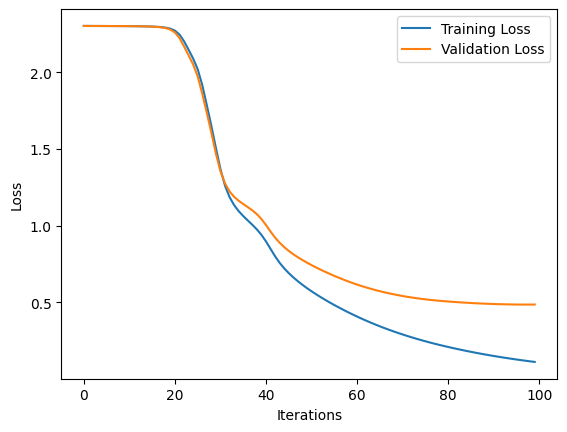

In [ ]:
# Set hyperparameters
learning_rate = 0.01
num_iterations = 100
nh1 = 128
nh2 = 64
batch_size = 32

# Train the model
parameters_mb, history_mb = create_nn_model_mb(train_X, train_Y, test_X, test_Y, num_iterations, learning_rate, nh1, nh2, batch_size)

# Plot the learning curves
plt.plot(history_mb['train_loss'], label='Training Loss')
plt.plot(history_mb['val_loss'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Accuracy: 86.0%


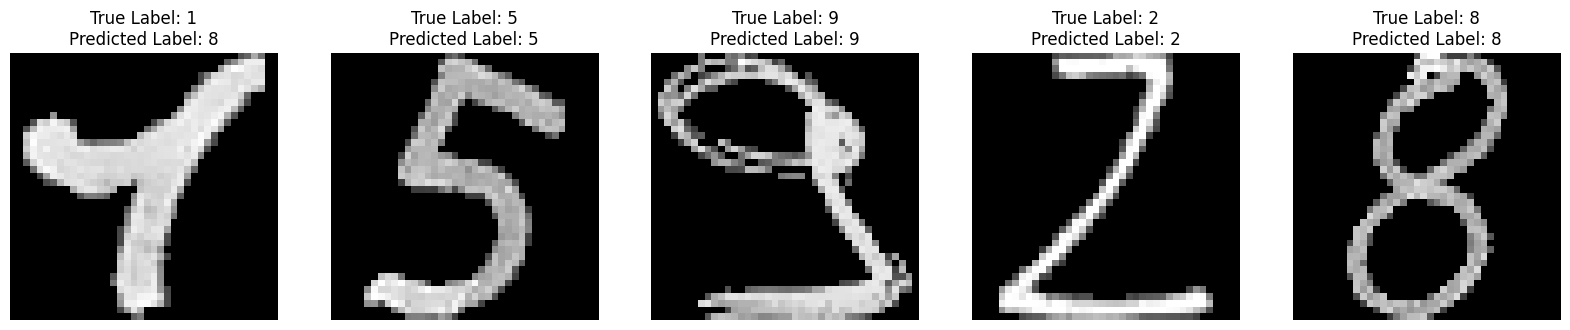

In [ ]:
# Predicting and evaluating the NN model with mini batch gradient descent

def predict(parameters, X):
    Yhat = forward_pass(parameters, X)
    predictions = np.argmax(Yhat, axis=0)
    return predictions

# Use the trained parameters to make predictions on the test set
test_predictions_mb = predict(parameters_mb, tf.convert_to_tensor(test_X, dtype=tf.float32))

# Compare predicted labels with true labels to calculate test accuracy
correct_predictions_mb = np.sum(test_predictions_mb == np.argmax(test_Y, axis=0))
total_samples = test_Y.shape[1]
test_accuracy = correct_predictions_mb / total_samples * 100
print("Test Accuracy: {:.1f}%".format(test_accuracy))

# Plot a few images in the test set  with their predicted labels
num_images_to_plot = 5
random_indices = np.random.choice(test_X.shape[1], num_images_to_plot, replace=False)

plt.figure(figsize=(20, 5))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(1, num_images_to_plot, i)
    plt.imshow(test_X[:, idx].reshape(40, 40), cmap='gray')
    plt.title("True Label: {}\nPredicted Label: {}".format(test_Y[:, idx].argmax(), test_predictions_mb[idx]))
    plt.axis('off')

plt.show()

Let's create a model without mini batch parameter, which we did in our last assignment. This is the same model we will run to see how the learning curve is showing.

iteration 0: train_loss:2.3026506900787354 val_loss2.302661418914795
iteration 1: train_loss:2.3026492595672607 val_loss2.3026602268218994
iteration 2: train_loss:2.302647829055786 val_loss2.3026585578918457
iteration 3: train_loss:2.3026461601257324 val_loss2.3026576042175293
iteration 4: train_loss:2.3026444911956787 val_loss2.302656412124634
iteration 5: train_loss:2.302642822265625 val_loss2.302654981613159
iteration 6: train_loss:2.3026416301727295 val_loss2.3026535511016846
iteration 7: train_loss:2.302640199661255 val_loss2.302652597427368
iteration 8: train_loss:2.302638530731201 val_loss2.3026514053344727
iteration 9: train_loss:2.3026371002197266 val_loss2.302649974822998
iteration 10: train_loss:2.302635669708252 val_loss2.3026487827301025
iteration 11: train_loss:2.3026340007781982 val_loss2.302647352218628
iteration 12: train_loss:2.3026323318481445 val_loss2.3026461601257324
iteration 13: train_loss:2.30263090133667 val_loss2.302644729614258
iteration 14: train_loss:2.302

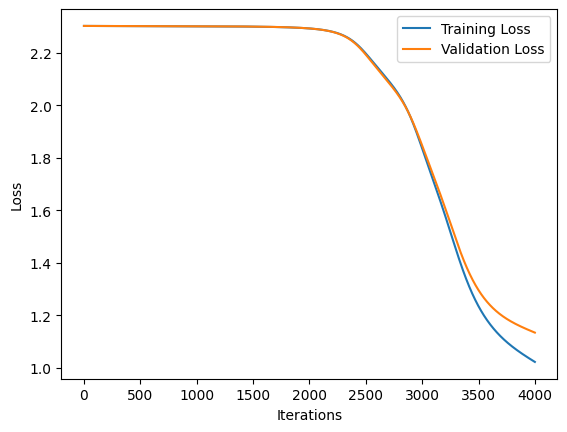

In [ ]:
#Creating the Neural Network Model

def create_nn_model(train_X, train_Y, val_X, val_Y, num_iterations, learning_rate, nh1, nh2):
    nx, m = train_X.shape
    ny = 10  # Number of output neurons for multi-class classification

    parameters = initialize_parameters(nx, nh1, nh2, ny)

    val_losses = []
    train_losses = []

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            train_Yhat = forward_pass(parameters, tf.convert_to_tensor(train_X, dtype=tf.float32))
            train_loss = compute_loss(tf.convert_to_tensor(train_Y, dtype=tf.float32), train_Yhat)

        val_Yhat = forward_pass(parameters, tf.convert_to_tensor(val_X, dtype=tf.float32))
        val_loss = compute_loss(tf.convert_to_tensor(val_Y, dtype=tf.float32), val_Yhat)

        print("iteration {}: train_loss:{} val_loss{}".format(i, train_loss.numpy(), val_loss.numpy()))

        train_losses.append(train_loss.numpy())
        val_losses.append(val_loss.numpy())

        gradients = backward_pass(parameters, train_loss, tape)
        parameters = update_parameters(parameters, gradients, learning_rate)

    history = {"val_loss": val_losses, "train_loss": train_losses}
    return parameters, history


# Set hyperparameters
learning_rate = 0.01
num_iterations = 4000
nh1 = 128
nh2 = 64

# Train the model
parameters, history = create_nn_model(train_X, train_Y, test_X, test_Y, num_iterations, learning_rate, nh1, nh2)

# Plot the learning curves
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interpreting the learning curves:

**Training Loss:**  It tends to decrease as the model learns to better fit the training data. With mini-batch gradient descent, we observe little fluctuations in the training loss due to the use of random mini-batches in each iteration.

**Validation Loss:**  It typically follows the training loss trend but might show signs of overfitting after few epochs the gap is increasing.

**Comparison with the model without mini-batch gradient descent:**

When using mini-batch training, the training and validation loss curves initially appear close for a few epochs. However, as training progresses, the gap between them starts to increase. This is because the mini-batch updates can lead to overfitting on the training data, while the validation loss reflects the model's performance on unseen data. In contrast, training without mini-batches may not show a significant gap between training and validation loss, but this might indicate underfitting (the model is not learning enough from the data).



Moreover, model accuracy has increased with mini batch gradient descent model.



2. **Modify your update_parameters method to update parameters using Nesterov Momentum (5pt) .**

The updae rule for nesterov Momentum is as follows:

𝑣= 𝜇∗𝑣−𝑙𝑒𝑎𝑟𝑛𝑖𝑛𝑔𝑅𝑎𝑡𝑒∗𝑔

𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟=𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟+𝜇∗𝑣−𝑙𝑒𝑎𝑟𝑛𝑖𝑛𝑔𝑅𝑎𝑡𝑒∗𝑔

Where 𝑔 is the gradient of loss with respect to the 𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟 𝑦𝑜𝑢 𝑤𝑎𝑛𝑡 𝑡𝑜 𝑢𝑝𝑑𝑎𝑡𝑒 (𝑖.𝑒.,𝑤𝑒𝑖𝑔ℎ𝑡𝑠 𝑎𝑛𝑑 𝑏𝑖𝑎𝑠𝑒𝑠) and 𝜇∈[0,1] is momentum decay rate ( it should be provided as input to the update_parameter method).
𝑣 is initially zero.

In your initialize_parameters method, you should define a 𝑣 variable for each parameter (i.e., weights and biases) with the same shape as the parameter and set it to zero.
Try re-training your neural network with different values of 𝜇 ( e.g., 0.9, 0.95, and 0.99) and interpret the learning curves.

Training with mu=0.9
epoch 0: train_loss:2.3026795559101276 val_loss2.302518844604492
epoch 1: train_loss:2.302526684494706 val_loss2.302403211593628
epoch 2: train_loss:2.3023893446535677 val_loss2.3022961616516113
epoch 3: train_loss:2.302260751122827 val_loss2.3021910190582275
epoch 4: train_loss:2.3021346728006997 val_loss2.3020846843719482
epoch 5: train_loss:2.302006283321896 val_loss2.3019726276397705
epoch 6: train_loss:2.30187041480262 val_loss2.3018503189086914
epoch 7: train_loss:2.3017218198862164 val_loss2.301710367202759
epoch 8: train_loss:2.3015548645913064 val_loss2.301548480987549
epoch 9: train_loss:2.301362254598119 val_loss2.3013556003570557
epoch 10: train_loss:2.301133714280687 val_loss2.3011207580566406
epoch 11: train_loss:2.3008573785558477 val_loss2.3008313179016113
epoch 12: train_loss:2.300517110137252 val_loss2.3004679679870605
epoch 13: train_loss:2.300088802973429 val_loss2.300001621246338
epoch 14: train_loss:2.299538940996737 val_loss2.299393653869629


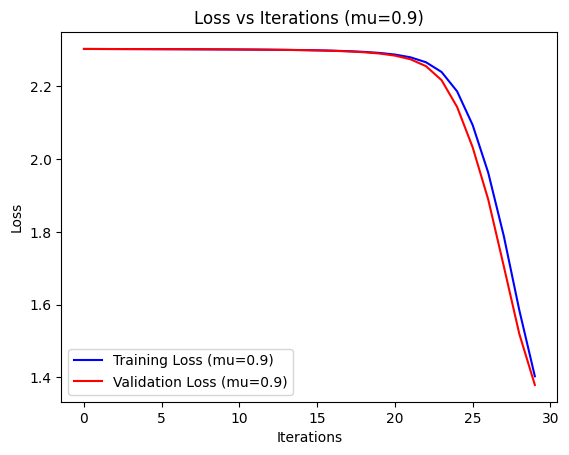

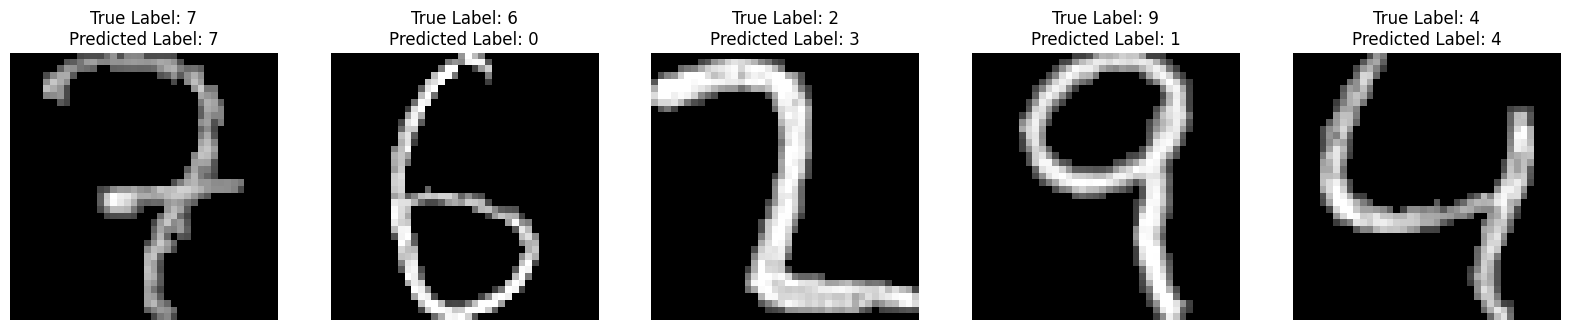

Training with mu=0.95
epoch 0: train_loss:2.302724883363054 val_loss2.302469491958618
epoch 1: train_loss:2.3024246284553596 val_loss2.302248001098633
epoch 2: train_loss:2.3021751459654385 val_loss2.302031993865967
epoch 3: train_loss:2.3019173811147877 val_loss2.301785945892334
epoch 4: train_loss:2.301610308724481 val_loss2.3014652729034424
epoch 5: train_loss:2.301203349689106 val_loss2.301008939743042
epoch 6: train_loss:2.300615375106399 val_loss2.300316095352173
epoch 7: train_loss:2.2997018195487358 val_loss2.299186944961548
epoch 8: train_loss:2.2981674456381582 val_loss2.297192335128784
epoch 9: train_loss:2.2953388669469335 val_loss2.2932870388031006
epoch 10: train_loss:2.2894195887419553 val_loss2.284393787384033
epoch 11: train_loss:2.274462049071853 val_loss2.259186267852783
epoch 12: train_loss:2.226381997804384 val_loss2.170745611190796
epoch 13: train_loss:2.0760833057197363 val_loss1.9537230730056763
epoch 14: train_loss:1.7811890572041005 val_loss1.612715482711792
e

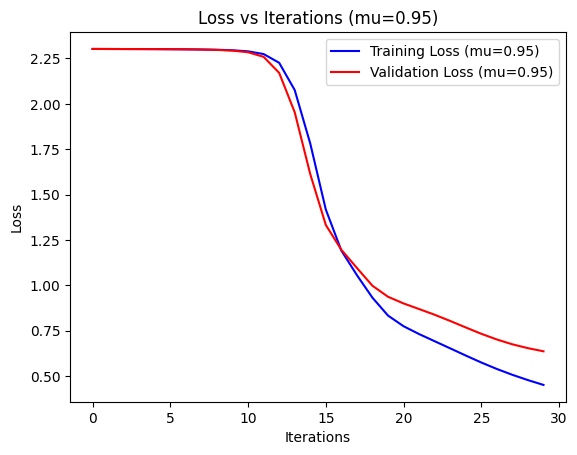

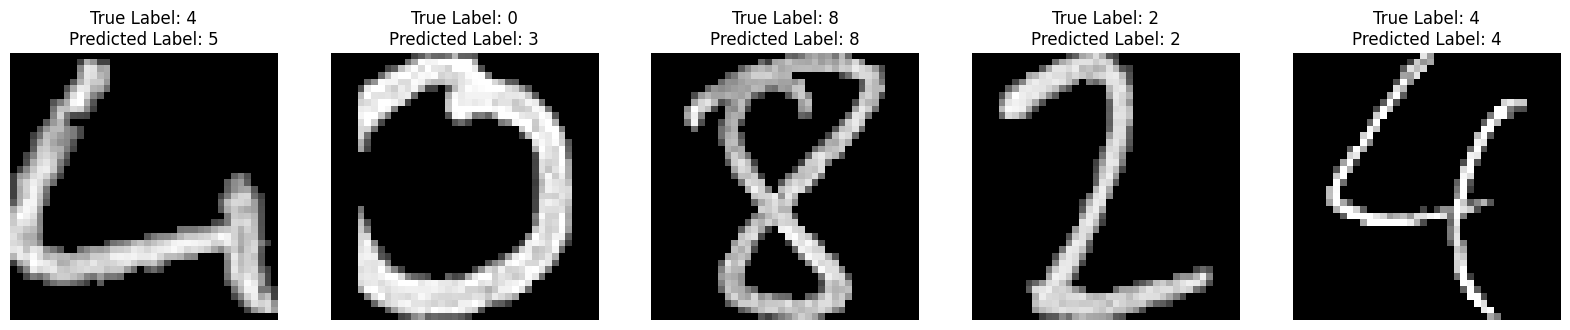

Training with mu=0.99
epoch 0: train_loss:2.302907045897063 val_loss2.3025550842285156
epoch 1: train_loss:2.3018904591465854 val_loss2.301683187484741
epoch 2: train_loss:2.300365291200243 val_loss2.2991039752960205
epoch 3: train_loss:2.2942876923191653 val_loss2.2855381965637207
epoch 4: train_loss:2.2376161566725723 val_loss2.1114134788513184
epoch 5: train_loss:1.7090922755164069 val_loss1.3281313180923462
epoch 6: train_loss:1.0657375100496653 val_loss1.0251846313476562
epoch 7: train_loss:0.7654432350987787 val_loss0.8161756992340088
epoch 8: train_loss:0.5695443596388843 val_loss0.6682978272438049
epoch 9: train_loss:0.4389359471765724 val_loss0.5811755657196045
epoch 10: train_loss:0.352166335056494 val_loss0.5320858359336853
epoch 11: train_loss:0.28633439248880826 val_loss0.49862104654312134
epoch 12: train_loss:0.22527770587318652 val_loss0.488855242729187
epoch 13: train_loss:0.1769489114181147 val_loss0.4809756875038147
epoch 14: train_loss:0.14837018608509958 val_loss0.5

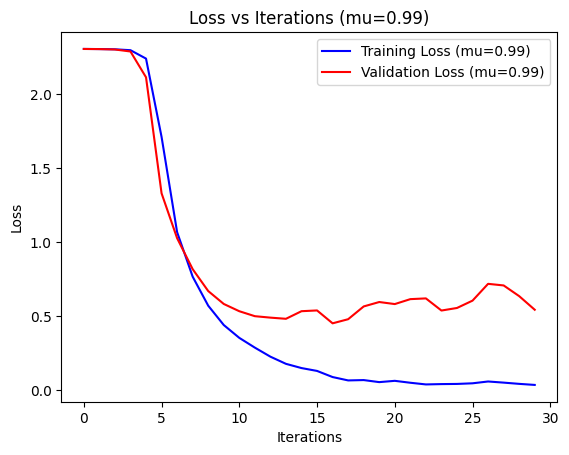

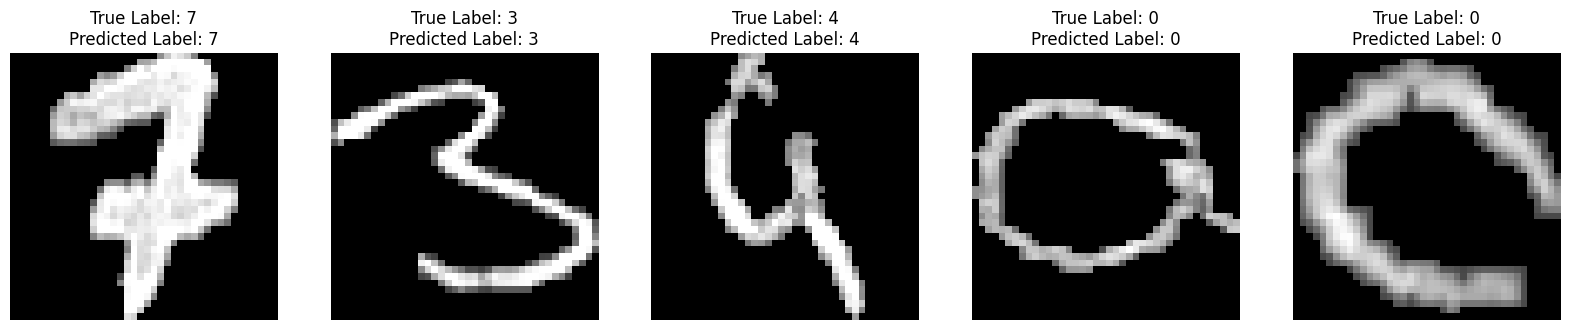

In [ ]:
def initialize_parameters(nx, nh1, nh2, ny):
    tf.random.set_seed(20)
    W1 = tf.Variable(tf.random.normal(shape=(nh1, nx), stddev=0.01), name="W1")
    b1 = tf.Variable(tf.zeros(shape=(nh1, 1), name="b1"))
    W2 = tf.Variable(tf.random.normal(shape=(nh2, nh1), stddev=0.01), name="W2")
    b2 = tf.Variable(tf.zeros(shape=(nh2, 1), name="b2"))
    W3 = tf.Variable(tf.random.normal(shape=(ny, nh2), stddev=0.01), name="W3")
    b3 = tf.Variable(tf.zeros(shape=(ny, 1), name="b3"))

    # Initialize velocity for each parameter
    v_W1 = tf.Variable(tf.zeros_like(W1))
    v_b1 = tf.Variable(tf.zeros_like(b1))
    v_W2 = tf.Variable(tf.zeros_like(W2))
    v_b2 = tf.Variable(tf.zeros_like(b2))
    v_W3 = tf.Variable(tf.zeros_like(W3))
    v_b3 = tf.Variable(tf.zeros_like(b3))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    velocities = {"v_W1": v_W1, "v_b1": v_b1, "v_W2": v_W2, "v_b2": v_b2, "v_W3": v_W3, "v_b3": v_b3}

    return parameters, velocities

# Modify update_parameters to use Nesterov Momentum
def update_parameters(parameters, velocities, gradients, learning_rate, mu):
    for param, grad, vel in zip(parameters.values(), gradients, velocities.values()):
        # Update velocity
        vel.assign(mu * vel - learning_rate * grad)
        # Update parameter using velocity
        param.assign_add(mu * vel - learning_rate * grad)

    return parameters

#Forward Pass:
def forward_pass(parameters, X):
    X = tf.cast(X, tf.float32)

    Z1 = tf.matmul(parameters["W1"], X) + parameters["b1"]
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(parameters["W2"], A1) + parameters["b2"]
    A2 = tf.nn.relu(Z2)
    Z3 = tf.matmul(parameters["W3"], A2) + parameters["b3"]

    # Apply softmax activation for multi-class classification
    Yhat = tf.nn.softmax(Z3, axis=0)

    return Yhat

#Loss calculations
def compute_loss(Y, Yhat):
    # Cross-entropy loss
    loss = -tf.reduce_mean(tf.reduce_sum(Y * tf.math.log(Yhat + 1e-10), axis=0))
    return loss

#Backward Pass
def backward_pass(parameters, loss, tape):
    gradients = tape.gradient(loss, parameters.values())
    return gradients

# Create a new create_nn_model function to utilize the modified update_parameters
def create_nn_model_mu(train_X, train_Y, val_X, val_Y, num_iterations, learning_rate, nh1, nh2, batch_size, mu):
    nx, m = train_X.shape
    ny = train_Y.shape[0]

    parameters, velocities = initialize_parameters(nx, nh1, nh2, ny)

    val_losses = []
    train_losses = []

    # Adjusted calculation for number of batches
    num_batches = (m + batch_size - 1) // batch_size

    for i in range(num_iterations):
        epoch_train_loss = 0  # Initialize epoch training loss
        train_loss = []   # Initialize train_loss

        for batch in range(num_batches):
            start = batch * batch_size
            end = min(start + batch_size, m)
            X_batch = train_X[:, start:end]
            Y_batch = train_Y[:, start:end]

            with tf.GradientTape() as tape:
                train_Yhat = forward_pass(parameters, tf.convert_to_tensor(X_batch, dtype=tf.float32))
                train_loss = compute_loss(tf.convert_to_tensor(Y_batch, dtype=tf.float32), train_Yhat)

            gradients = backward_pass(parameters, train_loss, tape)
            parameters = update_parameters(parameters, velocities, gradients, learning_rate, mu)

            epoch_train_loss = epoch_train_loss + train_loss.numpy()  # Accumulate loss for the current batch


        epoch_train_loss = epoch_train_loss/num_batches
        train_losses.append(epoch_train_loss)  # Append epoch loss to train_losses


        # Calculate validation loss after each epoch
        val_Yhat = forward_pass(parameters, tf.convert_to_tensor(val_X, dtype=tf.float32))
        val_loss = compute_loss(tf.convert_to_tensor(val_Y, dtype=tf.float32), val_Yhat)
        val_losses.append(val_loss.numpy())

        print("epoch {}: train_loss:{} val_loss{}".format(i, epoch_train_loss, val_loss.numpy()))

    history = {"val_loss": val_losses, "train_loss": train_losses}
    return parameters, history

# Set hyperparameters
learning_rate = 0.001
num_iterations = 30
nh1 = 128
nh2 = 64
batch_size = 32
# Different values of momentum
mu_list = [0.9, 0.95, 0.99]

# Train the model with different values of mu
for mu in mu_list:
    print(f"Training with mu={mu}")
    parameters_mu, history = create_nn_model_mu(train_X, train_Y, test_X, test_Y, num_iterations, learning_rate, nh1, nh2, batch_size, mu)
    plt.figure()
    plt.plot(history['train_loss'], 'b', label=f'Training Loss (mu={mu})')
    plt.plot(history['val_loss'], 'r', label=f'Validation Loss (mu={mu})')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss vs Iterations (mu={mu})')

    # Use the trained parameters to make predictions on the test set
    test_predictions_mu = predict(parameters_mu, tf.convert_to_tensor(test_X, dtype=tf.float32))

    # Compare predicted labels with true labels to calculate test accuracy
    correct_predictions = np.sum(test_predictions_mu == np.argmax(test_Y, axis=0))
    total_samples = test_Y.shape[1]
    test_accuracy = correct_predictions / total_samples * 100
    print(f"Test Accuracy (mu={mu}): {test_accuracy:.1f}%")

    # Plot a few images in the test set along with their predicted labels
    num_images_to_plot = 5
    random_indices = np.random.choice(test_X.shape[1], num_images_to_plot, replace=False)

    plt.figure(figsize=(20, 5))
    for i, idx in enumerate(random_indices, 1):
        plt.subplot(1, num_images_to_plot, i)
        plt.imshow(test_X[:, idx].reshape(40, 40), cmap='gray')
        plt.title("True Label: {}\nPredicted Label: {}".format(test_Y[:, idx].argmax(), test_predictions_mu[idx]))
        plt.axis('off')

    plt.show()

After adding momentum, we observed some improvements in the model performance.

For mu = 0.9: The learning curve remains relatively flat for a few epochs before gradually decreasing. There isn't a significant gap between the training and validation loss, but this doesn't translate to high accuracy with the test data.

For mu = 0.95: Increasing the momentum further enhances the influence of previous updates. Here, we observe a similar trend with a relatively flat learning curve for the initial epochs followed by a decrease. The accuracy is better compared to the momentum with mu = 0.9.

For mu = 0.99: A very high value of mu, such as 0.99, makes the optimization process even smoother. With mu = 0.99, we notice more fluctuations in the learning curve across epochs compared to other values of mu, but this is accompanied by higher accuracy.

I experimented with different combinations of learning rate and momentum. Interestingly, I found that both higher learning rates with lower momentum and lower learning rates with higher momentum tend to yield better accuracy in this model. In this case, I opted for a lower learning rate with higher momentum, which resulted in better accuracy. Despite some variations in the validation loss compared to other momentums, the model performs well overall.

# **Reduce Learning Rate on Plateau(5pt) :**

Reduce the learning rate by half if no improvement is seen in validation loss for 10 epochs. You should monitor and keep track of the best validation loss and the parameters for the model with that loss. If no improvement is seen in validation loss for 10 epochs, then reduce the learning rate by 0.5 and continue the training with that learning rate. Stop training if the learning rate is reduced to a
minimum value ( e.g., 1e-4) and return the parameters with the lowest validation loss.

epoch 0: train_loss:2.302825390755593 val_loss2.3024215698242188
epoch 1: train_loss:2.301624298095703 val_loss2.301241636276245
epoch 2: train_loss:2.299386617299673 val_loss2.297261953353882
epoch 3: train_loss:2.288591410662677 val_loss2.2708468437194824
epoch 4: train_loss:2.175155429152755 val_loss1.9611135721206665
epoch 5: train_loss:1.495107308701352 val_loss1.1538984775543213
epoch 6: train_loss:0.9085830168144123 val_loss0.9860073328018188
epoch 7: train_loss:0.7221157387033239 val_loss0.7807842493057251
epoch 8: train_loss:0.5211424273145091 val_loss0.627478301525116
epoch 9: train_loss:0.39641281076379725 val_loss0.5648301839828491
epoch 10: train_loss:0.32093540253537195 val_loss0.5099711418151855
epoch 11: train_loss:0.2551417872309685 val_loss0.48005813360214233
epoch 12: train_loss:0.20547030654710693 val_loss0.4620193839073181
epoch 13: train_loss:0.16823062916529608 val_loss0.5184423923492432
epoch 14: train_loss:0.13630531761828843 val_loss0.5679428577423096
epoch 15

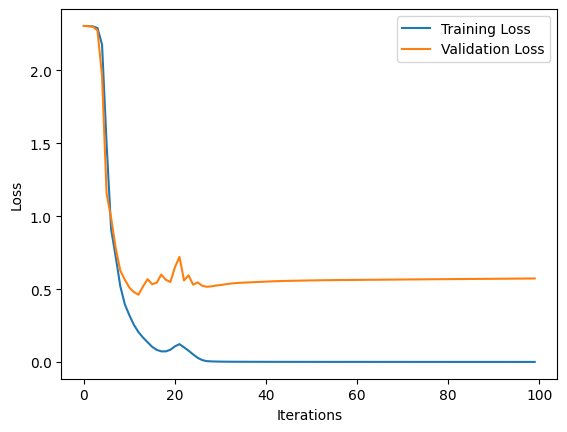

Best Parameters:
W1:
[[-0.02085437  0.01866391  0.01303958 ...  0.01135506 -0.00068393
  -0.02710604]
 [-0.00638591  0.01777487 -0.00625102 ... -0.0135013  -0.02190342
  -0.01678702]
 [-0.00358494  0.00258934  0.00966893 ...  0.00429086 -0.01014254
   0.00594161]
 ...
 [ 0.00207208 -0.00173876  0.01744212 ... -0.00305538 -0.0014465
  -0.00210311]
 [-0.00820849  0.00232205  0.00764629 ... -0.01300319 -0.00310775
   0.00225077]
 [ 0.0249713   0.01420243 -0.01537449 ...  0.00368684 -0.00175021
   0.01113094]]
b1:
[[ 1.0706624e-01]
 [ 1.8618616e-01]
 [ 1.5982701e-02]
 [-6.2890276e-02]
 [ 5.8442038e-02]
 [ 3.2657463e-02]
 [-1.3553600e-02]
 [-1.0060068e-03]
 [ 9.6418418e-02]
 [ 2.6995407e-02]
 [ 2.5515171e-02]
 [-2.6752637e-03]
 [ 3.1163154e-02]
 [-1.0515926e-02]
 [ 1.0291452e-02]
 [ 2.7705472e-02]
 [ 9.7377533e-03]
 [ 1.3197353e-01]
 [ 7.4122600e-02]
 [-7.2899275e-02]
 [ 3.0579541e-02]
 [ 1.9527411e-02]
 [ 9.9782869e-02]
 [ 2.2011360e-02]
 [ 2.4308138e-02]
 [-6.4992500e-03]
 [-1.6663142e-02

In [ ]:
# Parameter Initialization
def initialize_parameters(nx, nh1, nh2, ny):
    tf.random.set_seed(21)
    W1 = tf.Variable(tf.random.normal(shape=(nh1, nx), stddev=0.01), name="W1")
    b1 = tf.Variable(tf.zeros(shape=(nh1, 1), name="b1"))
    W2 = tf.Variable(tf.random.normal(shape=(nh2, nh1), stddev=0.01), name="W2")
    b2 = tf.Variable(tf.zeros(shape=(nh2, 1), name="b2"))
    W3 = tf.Variable(tf.random.normal(shape=(ny, nh2), stddev=0.01), name="W3")
    b3 = tf.Variable(tf.zeros(shape=(ny, 1), name="b3"))

    # Initialize velocity for each parameter
    v_W1 = tf.Variable(tf.zeros_like(W1), trainable=False)
    v_b1 = tf.Variable(tf.zeros_like(b1), trainable=False)
    v_W2 = tf.Variable(tf.zeros_like(W2), trainable=False)
    v_b2 = tf.Variable(tf.zeros_like(b2), trainable=False)
    v_W3 = tf.Variable(tf.zeros_like(W3), trainable=False)
    v_b3 = tf.Variable(tf.zeros_like(b3), trainable=False)

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    velocities = {"v_W1": v_W1, "v_b1": v_b1, "v_W2": v_W2, "v_b2": v_b2, "v_W3": v_W3, "v_b3": v_b3}

    return parameters, velocities

# Forward Pass
def forward_pass(parameters, X):
    X = tf.cast(X, tf.float32)

    Z1 = tf.matmul(parameters["W1"], X) + parameters["b1"]
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(parameters["W2"], A1) + parameters["b2"]
    A2 = tf.nn.relu(Z2)
    Z3 = tf.matmul(parameters["W3"], A2) + parameters["b3"]

    # Apply softmax activation for multi-class classification
    Yhat = tf.nn.softmax(Z3, axis=0)

    return Yhat

# Loss calculations
def compute_loss(Y, Yhat):
    loss = -tf.reduce_mean(tf.reduce_sum(Y * tf.math.log(Yhat + 1e-10), axis=0))
    return loss

# Backward Pass
def backward_pass(parameters, loss, tape):
    gradients = tape.gradient(loss, parameters.values())
    return gradients

# Modify update_parameters to use Nesterov Momentum
def update_parameters(parameters, velocities, gradients, learning_rate, mu):
    for param, grad, vel in zip(parameters.values(), gradients, velocities.values()):
        # Update velocity
        vel.assign(mu * vel - learning_rate * grad)
        # Update parameter using velocity
        param.assign_add(mu * vel - learning_rate * grad)

    return parameters

# Create a new create_nn_model function to utilize the modified update_parameters
def create_nn_model_ReduceLROnPlateau(train_X, train_Y, val_X, val_Y, num_iterations, learning_rate, nh1, nh2, batch_size, mu):
    nx, m = train_X.shape
    ny = train_Y.shape[0]

    parameters, velocities = initialize_parameters(nx, nh1, nh2, ny)

    best_val_loss = True # Generated AI help code
    best_parameters = None # Generated AI help code
    no_improvement_count = 0
    min_learning_rate = 0.0001

    val_losses = []
    train_losses = []

    num_batches = (m + batch_size - 1) // batch_size

    for i in range(num_iterations):
        epoch_train_loss = 0
        train_loss = []

        for batch in range(num_batches):
            start = batch * batch_size
            end = min(start + batch_size, m)
            X_batch = train_X[:, start:end]
            Y_batch = train_Y[:, start:end]

            with tf.GradientTape() as tape:
                train_Yhat = forward_pass(parameters, tf.convert_to_tensor(X_batch, dtype=tf.float32))
                train_loss = compute_loss(tf.convert_to_tensor(Y_batch, dtype=tf.float32), train_Yhat)

            gradients = backward_pass(parameters, train_loss, tape)
            parameters = update_parameters(parameters, velocities, gradients, learning_rate, mu)

            epoch_train_loss = epoch_train_loss + train_loss.numpy()  # Accumulate loss for the current batch


        epoch_train_loss = epoch_train_loss/num_batches
        train_losses.append(epoch_train_loss)  # Append epoch loss to train_losses


        # Calculate validation loss after each epoch
        val_Yhat = forward_pass(parameters, tf.convert_to_tensor(val_X, dtype=tf.float32))
        val_loss = compute_loss(tf.convert_to_tensor(val_Y, dtype=tf.float32), val_Yhat)
        val_losses.append(val_loss.numpy())

        print("epoch {}: train_loss:{} val_loss{}".format(i, epoch_train_loss, val_loss.numpy()))

        # Check for improvement in validation loss
        if val_loss < best_val_loss: # Generated AI help code
            best_val_loss = val_loss # Generates AI help code
            best_parameters = parameters # Generates AI help code
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            #print("no_improvement_count", no_improvement_count)

        # If no improvement for 10 epochs, reduce learning rate by half
        if no_improvement_count >= 10:
            if learning_rate > min_learning_rate:
                learning_rate = learning_rate * 0.5
                no_improvement_count = 0
                print(f"Reducing learning rate to {learning_rate}")

    print("Best val_loss :" , best_val_loss)

    history = {"val_loss": val_losses, "train_loss": train_losses}
    return best_parameters, history

# Load the dataset
file_path = "German_digits.csv"
df = pd.read_csv(file_path)

# Extract features (X) and labels (Y)
X = df.iloc[:, :-1].values / 255.0
Y = df.iloc[:, -1].values

# Split the dataset into train and test
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=12)

# One-hot encode the labels
num_classes = 10
train_Y = pd.get_dummies(train_Y).values
test_Y = pd.get_dummies(test_Y).values

# Transpose the datasets
train_X = train_X.T
train_Y = train_Y.T
test_X = test_X.T
test_Y = test_Y.T

# print("train_X", train_X.shape)
# print("train_Y", train_Y.shape)
# print("test_X", test_X.shape)
# print("test_Y", test_Y.shape)

# Set hyperparameters
learning_rate = 0.001
num_iterations = 100
nh1 = 128
nh2 = 64
batch_size = 32
mu = 0.99

# Train the model
best_parameters, history = create_nn_model_ReduceLROnPlateau(train_X, train_Y, test_X, test_Y, num_iterations, learning_rate, nh1, nh2, batch_size, mu)

# Plot the learning curves
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print best parameters
print("Best Parameters:")
#print(best_parameters.items())
for item, value in best_parameters.items():
    print(f"{item}:")
    print(value.numpy())

The learning curve represent a decrease in loss over the initial epochs. However, around epochs 20 to 22, we observe fluctuations in the curve. Notably, the validation loss curve exhibits more variation during this period. The provided the result for showcases the best parameters and the best validation loss achieved by the model.  

**Get help of Generative AI to get the best parameters : Command given below:**

"logic to find best valuation loss of a model in python and best parameter".

# **Add Dropout Regularization (5pt)**

To add dropout regularization, you should modify the forward pass when applied to the training data and multiply the output of neurons in each layer (Z) by 1/𝑝* a random matrix of zeros and ones sampled from a Bernoulli distribution with probability 𝑝. Where (𝑝.=1- dropout_rate) is the probability of keeping a neuron. To get a random matrix of zeros and ones with the same shape as Z, you can first create a Bernoulli distribution with probability 𝑝 using tfp.distributions.Bernoulli then sample from this distribution.

Note: The dropout should only be applied during training that is, it should only be applied to the training data. The dropout should NOT be applied at the time of inference that is, it should NOT be applied to the validation and test sets.

Also note that the dropout should NOT be applied to the final layer because we do not want to drop any neuron in the final layer ( the final layer in a multi-class classification problem should have as many neurons as the number of output classes)
Re-train the model with dropout regularization ( use a dropout rate between 0.2-0.5 ( that is a keep probability 𝑝 between 0.8-0.5). Answer the following question:

*   Does dropout regularization help reduce the gap between train and validation losses?




epoch 0: train_loss:2.3029086246146813 val_loss2.3025577068328857
epoch 1: train_loss:2.3019051895485267 val_loss2.3017027378082275
epoch 2: train_loss:2.3005121441574783 val_loss2.2992660999298096
epoch 3: train_loss:2.2948066608325854 val_loss2.2854056358337402
epoch 4: train_loss:2.2360575328002104 val_loss2.108203411102295
epoch 5: train_loss:1.8416563465788558 val_loss1.5040284395217896
epoch 6: train_loss:1.324563377612346 val_loss1.0806617736816406
epoch 7: train_loss:0.9604579962051667 val_loss0.8230413794517517
epoch 8: train_loss:0.7130228860958202 val_loss0.6760463118553162
epoch 9: train_loss:0.5596933343389012 val_loss0.5584534406661987
epoch 10: train_loss:0.4639652549952 val_loss0.4871675372123718
epoch 11: train_loss:0.36355414288537996 val_loss0.4713653028011322
epoch 12: train_loss:0.3076675602713147 val_loss0.46048682928085327
epoch 13: train_loss:0.25378194176130464 val_loss0.41088005900382996
epoch 14: train_loss:0.21327075714597832 val_loss0.39485639333724976
epoc

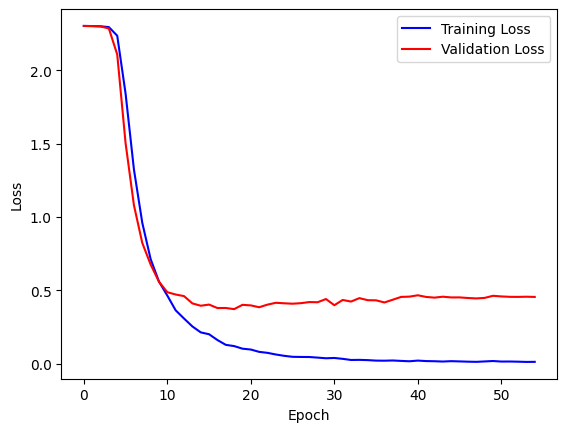

In [ ]:
import tensorflow_probability as tfp

# Parameter Initialization
def initialize_parameters(nx, nh1, nh2, ny):
    tf.random.set_seed(195)
    W1 = tf.Variable(tf.random.normal(shape=(nh1, nx), stddev=0.01), name="W1")
    b1 = tf.Variable(tf.zeros(shape=(nh1, 1), name="b1"))
    W2 = tf.Variable(tf.random.normal(shape=(nh2, nh1), stddev=0.01), name="W2")
    b2 = tf.Variable(tf.zeros(shape=(nh2, 1), name="b2"))
    W3 = tf.Variable(tf.random.normal(shape=(ny, nh2), stddev=0.01), name="W3")
    b3 = tf.Variable(tf.zeros(shape=(ny, 1), name="b3"))

    # Initialize velocity for each parameter
    v_W1 = tf.Variable(tf.zeros_like(W1), trainable=False)
    v_b1 = tf.Variable(tf.zeros_like(b1), trainable=False)
    v_W2 = tf.Variable(tf.zeros_like(W2), trainable=False)
    v_b2 = tf.Variable(tf.zeros_like(b2), trainable=False)
    v_W3 = tf.Variable(tf.zeros_like(W3), trainable=False)
    v_b3 = tf.Variable(tf.zeros_like(b3), trainable=False)

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    velocities = {"v_W1": v_W1, "v_b1": v_b1, "v_W2": v_W2, "v_b2": v_b2, "v_W3": v_W3, "v_b3": v_b3}

    return parameters, velocities

def dropout_samplemat(shape, dropout_rate, dtype=tf.float32):

    bernoulli_dist = tfp.distributions.Bernoulli(probs =1 - dropout_rate) # Generated AI code
    dropout_sample = bernoulli_dist.sample(shape) # Generated AI code
    #print(dropout_mask)

    return tf.cast(dropout_sample, dtype)

# Forward Pass with Dropout Regularization during training
def forward_pass(parameters, X, dropout_rate):
    X = tf.cast(X, tf.float32)

    # Apply dropout only during training
    Z1 = tf.matmul(parameters["W1"], X) + parameters["b1"]
    A1 = tf.nn.relu(Z1)
    dropout_1 = dropout_samplemat(tf.shape(A1), dropout_rate)
    A1 *= dropout_1 / (1 - dropout_rate)

    Z2 = tf.matmul(parameters["W2"], A1) + parameters["b2"]
    A2 = tf.nn.relu(Z2)
    dropout_2 = dropout_samplemat(tf.shape(A2), dropout_rate)
    A2 *= dropout_2 / (1 - dropout_rate)

    # Z1 = tf.matmul(parameters["W1"], X) + parameters["b1"]
    # A1 = tf.nn.relu(Z1)
    # Z2 = tf.matmul(parameters["W2"], A1) + parameters["b2"]
    # A2 = tf.nn.relu(Z2)
    # Z3 = tf.matmul(parameters["W3"], A2) + parameters["b3"]

    Z3 = tf.matmul(parameters["W3"], A2) + parameters["b3"]


    Yhat = tf.nn.softmax(Z3, axis=0)

    return Yhat

# Loss calculations
def compute_loss(Y, Yhat):
    loss = -tf.reduce_mean(tf.reduce_sum(Y * tf.math.log(Yhat + 1e-10), axis=0))
    return loss

# Backward Pass
def backward_pass(parameters, loss, tape):
    gradients = tape.gradient(loss, parameters.values())
    return gradients

# Modify update_parameters to use Nesterov Momentum
def update_parameters(parameters, velocities, gradients, learning_rate, mu):
    for param, grad, vel in zip(parameters.values(), gradients, velocities.values()):
        # Update velocity
        vel.assign(mu * vel - learning_rate * grad)
        # Update parameter using velocity
        param.assign_add(mu * vel - learning_rate * grad)

    return parameters

# Create a new create_nn_model function to utilize the modified update_parameters
def create_nn_model_Dropout(train_X, train_Y, val_X, val_Y, num_iterations, learning_rate, nh1, nh2, batch_size, mu, dropout_rate):
    nx, m = train_X.shape
    ny = train_Y.shape[0]

    parameters, velocities = initialize_parameters(nx, nh1, nh2, ny)

    best_val_loss = True
    best_parameters = None
    no_improvement_count = 0
    min_learning_rate = 0.0001

    val_losses = []
    train_losses = []

    num_batches = (m + batch_size - 1) // batch_size

    for i in range(num_iterations):
        epoch_train_loss = 0
        train_loss = []

        for batch in range(num_batches):
            start = batch * batch_size
            end = min(start + batch_size, m)
            X_batch = train_X[:, start:end]
            Y_batch = train_Y[:, start:end]

            with tf.GradientTape() as tape:
                train_Yhat = forward_pass(parameters, tf.convert_to_tensor(X_batch, dtype=tf.float32), dropout_rate)
                train_loss = compute_loss(tf.convert_to_tensor(Y_batch, dtype=tf.float32), train_Yhat)

            gradients = backward_pass(parameters, train_loss, tape)
            parameters = update_parameters(parameters, velocities, gradients, learning_rate, mu)

            epoch_train_loss = epoch_train_loss + train_loss.numpy()  # Accumulate loss for the current batch


        epoch_train_loss = epoch_train_loss/num_batches
        train_losses.append(epoch_train_loss)  # Append epoch loss to train_losses


        # Calculate validation loss after each epoch
        val_Yhat = forward_pass(parameters, tf.convert_to_tensor(val_X, dtype=tf.float32), dropout_rate=0.0)
        val_loss = compute_loss(tf.convert_to_tensor(val_Y, dtype=tf.float32), val_Yhat)
        val_losses.append(val_loss.numpy())

        print("epoch {}: train_loss:{} val_loss{}".format(i, epoch_train_loss, val_loss.numpy()))

        # Check for improvement in validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_parameters = parameters
            no_improvement_count = 0
        else:
            no_improvement_count += 1


        # If no improvement for 10 epochs, reduce learning rate by half
        if no_improvement_count >= 10:
            if learning_rate > min_learning_rate:
                learning_rate = learning_rate * 0.5
                no_improvement_count = 0
                print(f"Reducing learning rate to {learning_rate}")

    #print("Best val_loss :" , best_val_loss)

    history = {"val_loss": val_losses, "train_loss": train_losses}
    return best_parameters, history

# Load the dataset
file_path = "German_digits.csv"
df = pd.read_csv(file_path)

# Extract features (X) and labels (Y)
X = df.iloc[:, :-1].values / 255.0
Y = df.iloc[:, -1].values

# Split the dataset into train and test
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=12)

# One-hot encode the labels
num_classes = 10
train_Y = pd.get_dummies(train_Y).values
test_Y = pd.get_dummies(test_Y).values

# Transpose the datasets
train_X = train_X.T
train_Y = train_Y.T
test_X = test_X.T
test_Y = test_Y.T

# print("train_X", train_X.shape)
# print("train_Y", train_Y.shape)
# print("test_X", test_X.shape)
# print("test_Y", test_Y.shape)

# Set hyperparameters
learning_rate = 0.001
num_iterations = 55
nh1 = 128
nh2 = 64
batch_size = 32
mu = 0.99
dropout_rate = 0.2

# Train the model
best_parameters_dropout, history = create_nn_model_Dropout(train_X, train_Y, test_X, test_Y, num_iterations, learning_rate, nh1, nh2, batch_size, mu, dropout_rate)

# Plot the learning curves
plt.plot(history['train_loss'], 'b', label='Training Loss')
plt.plot(history['val_loss'], 'r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Yes, dropout regularization helps in reduce the gap between train and validation losses and increase the accuracy on test data. We can see the same in the above graph.

Test Accuracy: 90.4%


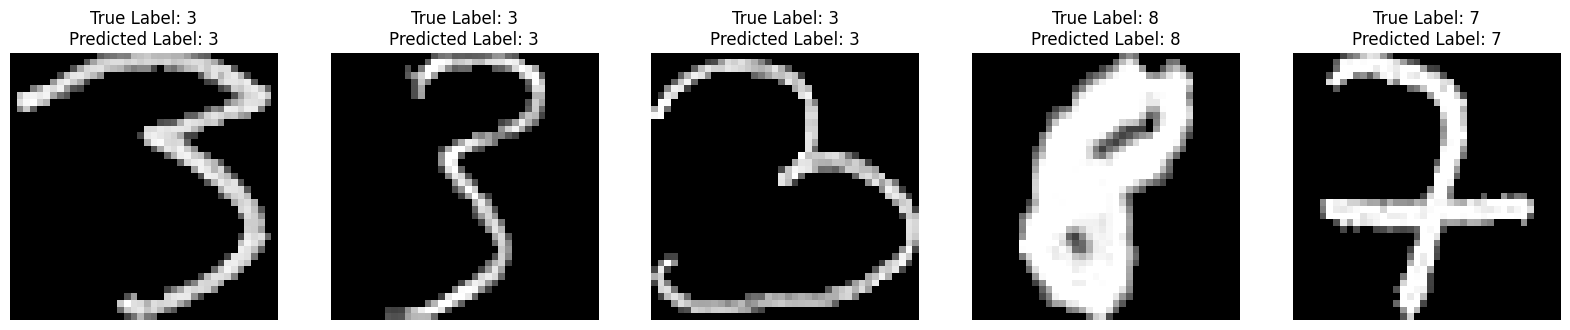

In [ ]:
# predicting and evaluating the NN model

def predict(parameters, X):
    Yhat = forward_pass(parameters, X, dropout_rate=0.0)
    predictions = np.argmax(Yhat, axis=0)
    return predictions

# Use the trained parameters to make predictions on the test set
test_predictions_do = predict(best_parameters_dropout, tf.convert_to_tensor(test_X, dtype=tf.float32))

# Compare predicted labels with true labels to calculate test accuracy
correct_predictions_do = np.sum(test_predictions_do == np.argmax(test_Y, axis=0))
total_samples = test_Y.shape[1]
test_accuracy_do = correct_predictions_do / total_samples * 100
print("Test Accuracy: {:.1f}%".format(test_accuracy_do))

# Plot a few images in the test set along with their predicted labels
num_images_to_plot = 5
random_indices = np.random.choice(test_X.shape[1], num_images_to_plot, replace=False)

plt.figure(figsize=(20, 5))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(1, num_images_to_plot, i)
    plt.imshow(test_X[:, idx].reshape(40, 40), cmap='gray')
    plt.title("True Label: {}\nPredicted Label: {}".format(test_Y[:, idx].argmax(), test_predictions_do[idx]))
    plt.axis('off')

plt.show()

Get help of Generative AI to get the best parameters : Command given below:

**"random matrix same shape of z".**

To complete this assignment  I have referred few articles the links are given below:

https://medium.com/@jaleeladejumo/gradient-descent-from-scratch-batch-gradient-descent-stochastic-gradient-descent-and-mini-batch-def681187473

https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%202/